# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

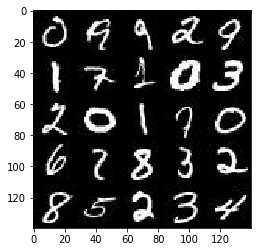

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

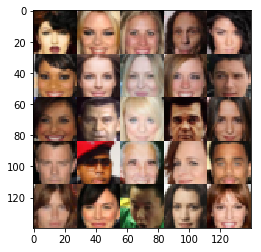

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32,(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real,  input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # TODO: Implement Function
        l1 = tf.layers.conv2d(images,32,5,strides=2,padding='same')
        relu1 = tf.maximum(0.2 * l1, l1)
        #14 *14 *64
    
        l2 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7 * 7 *128
    
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*64))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
   
    # TODO: Implement Function
    with tf.variable_scope("generator",reuse = not is_train):
        l1 = tf.layers.dense(z, 7*7*64)
        # Reshape it to start the convolutional stack
        l1 = tf.reshape(l1, (-1, 7, 7, 64))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2 * l1, l1)
        # 7x7x128 now
        l2 = tf.layers.conv2d_transpose(l1, 32, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2 * l2, l2)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_real,d_logits_real = discriminator(input_real)
    d_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

     # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return  d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _  = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
               
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.6599... Generator Loss: 5.1088
Epoch 1/2... Discriminator Loss: 1.9750... Generator Loss: 1.8754
Epoch 1/2... Discriminator Loss: 2.1799... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.6563... Generator Loss: 1.1912
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 1.1469
Epoch 1/2... Discriminator Loss: 1.5599... Generator Loss: 1.0403
Epoch 1/2... Discriminator Loss: 1.5614... Generator Loss: 1.3569
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 1.1245
Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.8190


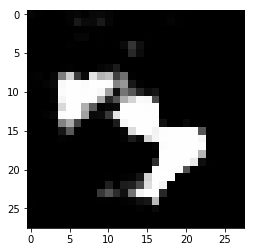

Epoch 1/2... Discriminator Loss: 1.5458... Generator Loss: 0.3723
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.6723


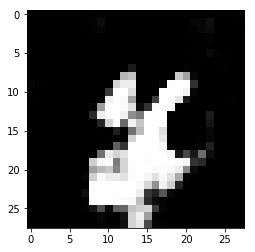

Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 1.0700
Epoch 1/2... Discriminator Loss: 1.5277... Generator Loss: 1.2368
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 1.6575... Generator Loss: 1.3163
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 1.0530
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.4810


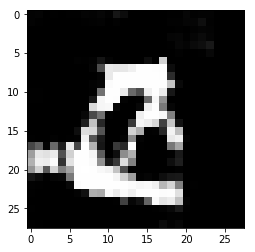

Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.6014


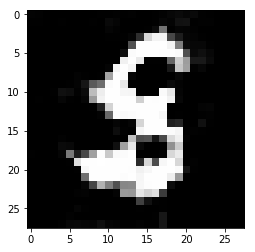

Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.5852... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.5145... Generator Loss: 0.4091


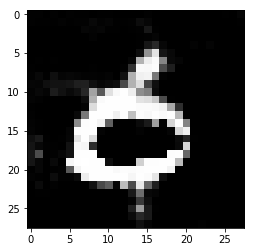

Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.5427
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.5155... Generator Loss: 0.3868
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.5106
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.5051... Generator Loss: 0.4300
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.6872


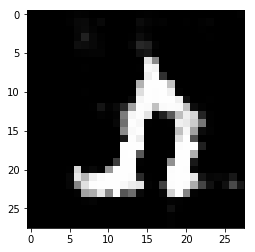

Epoch 2/2... Discriminator Loss: 1.5072... Generator Loss: 1.1233
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.5747
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.7466


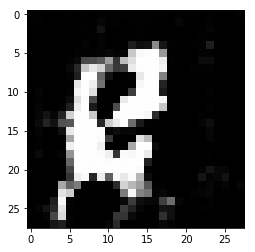

Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 1.0633
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.4734
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.4752... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.8024


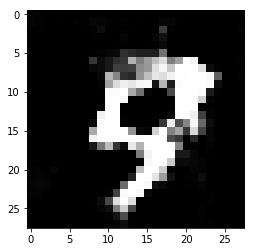

Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.6244
Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.9223
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.4965
Epoch 2/2... Discriminator Loss: 1.3717... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.5922
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.6901


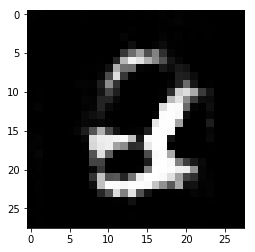

Epoch 2/2... Discriminator Loss: 1.4818... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.4120


In [38]:
batch_size = 128
z_dim = 100
learning_rate = 0.02
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3325... Generator Loss: 2.2552
Epoch 1/1... Discriminator Loss: 2.4069... Generator Loss: 0.1441
Epoch 1/1... Discriminator Loss: 2.2205... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.6488... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.6656


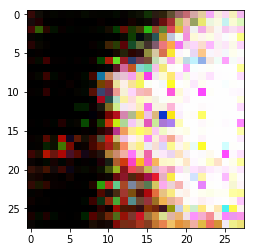

Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6902


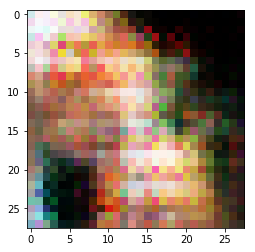

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6667


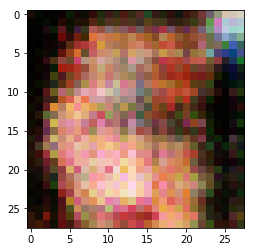

Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8008


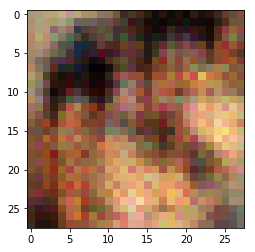

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6643


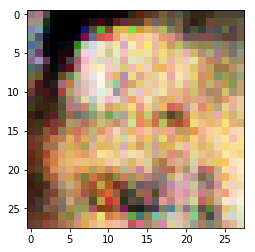

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7397


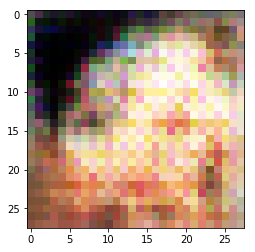

Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7277


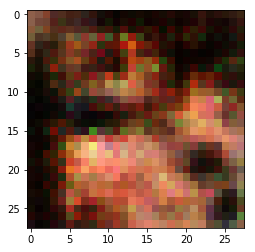

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6934


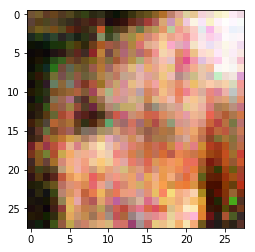

Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5494


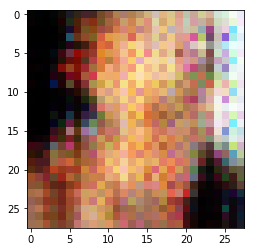

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6862


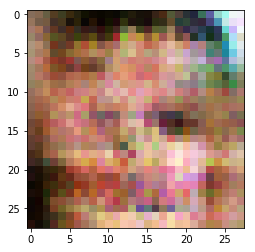

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6943


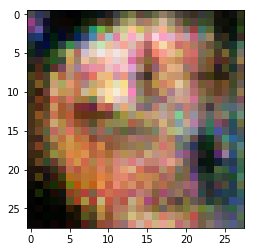

Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6944


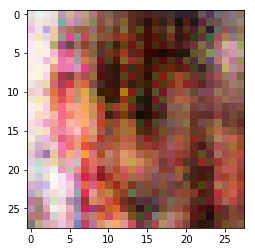

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6822


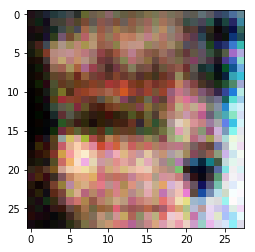

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7074


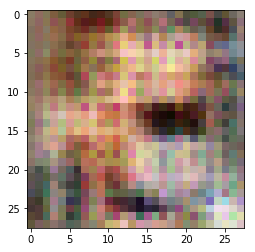

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7162


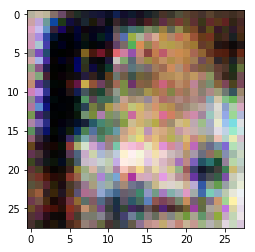

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7176


In [39]:
batch_size = 128
z_dim = 100
learning_rate = 0.02
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.